In [1]:

%pprint
%matplotlib inline
import sys
import os.path as osp

executable_path = sys.executable; scripts_folder = osp.join(osp.dirname(executable_path), 'Scripts')
py_folder = osp.abspath('../py'); ffmpeg_folder = r'C:\ffmpeg\bin'
if (scripts_folder not in sys.path): sys.path.insert(1, scripts_folder)
if (py_folder not in sys.path): sys.path.insert(1, py_folder)
if (ffmpeg_folder not in sys.path): sys.path.insert(1, ffmpeg_folder)
from jobpostlib import (crf, cu, datetime, duration, hau, hc, humanize, ihu, lru, nu, osp, scrfcu, slrcu, ssgdcu, su, t0, time, wsu, speech_engine)
from pandas import DataFrame
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date
import matplotlib.dates as mdates

Pretty printing has been turned OFF
======== Neo4j/4.4.7 ========
Utility libraries created in 5 seconds


In [2]:

# Cypher for job hunting activity since the beginning of recorded history
cypher_str = '''
    // Count job hunting activity since the beginning of recorded history
    CALL {
        
        MATCH (fn:FileNames)
        WITH fn, [date IN fn.technical_interview_dates 
                  WHERE date <= date()] AS action_dates
        WHERE size(action_dates) > 0
        UNWIND action_dates AS action_date
        RETURN
            action_date,
            0 AS application_count,
            0 AS rejection_count,
            0 AS screen_count,
            1 AS interview_count
        
        UNION
        
        MATCH (fn:FileNames)
        WHERE (fn.recruiter_screen_completion_date <= date())
        RETURN
            fn.recruiter_screen_completion_date AS action_date,
            0 AS application_count,
            0 AS rejection_count,
            COUNT(fn.recruiter_screen_completion_date) AS screen_count,
            0 AS interview_count
        
        UNION
        
        MATCH (fn:FileNames)
        WHERE (fn.rejection_email_date <= date())
        RETURN
            fn.rejection_email_date AS action_date,
            0 AS application_count,
            COUNT(fn.rejection_email_date) AS rejection_count,
            0 AS screen_count,
            0 AS interview_count
        
        UNION
        
        MATCH (fn:FileNames)
        WHERE (fn.opportunity_application_email_date <= date())
        RETURN
            fn.opportunity_application_email_date AS action_date,
            COUNT(fn.opportunity_application_email_date) AS application_count,
            0 AS rejection_count,
            0 AS screen_count,
            0 AS interview_count
    
    }
    WITH action_date, SUM(application_count) AS total_applications, SUM(rejection_count) AS total_rejections, SUM(screen_count) AS total_screens, SUM(interview_count) AS total_interviews
    RETURN
        action_date,
        total_applications,
        total_rejections,
        total_screens,
        total_interviews
    ORDER BY action_date ASC;'''

In [3]:

# Cypher for job hunting activity since last day of work
cypher_str = '''
    // Count job hunting activity since last day of work
    CALL {
        
        MATCH (fn:FileNames)
        WITH fn, [date IN fn.technical_interview_dates 
                  WHERE date >= date("2024-06-13") AND date <= date()] AS action_dates
        WHERE size(action_dates) > 0
        UNWIND action_dates AS action_date
        RETURN
            action_date,
            0 AS application_count,
            0 AS rejection_count,
            0 AS screen_count,
            1 AS interview_count
        
        UNION
        
        MATCH (fn:FileNames)
        WHERE ((fn.recruiter_screen_completion_date <= date()) AND (fn.recruiter_screen_completion_date >= date("2024-06-13")))
        RETURN
            fn.recruiter_screen_completion_date AS action_date,
            0 AS application_count,
            0 AS rejection_count,
            COUNT(fn.recruiter_screen_completion_date) AS screen_count,
            0 AS interview_count
        
        UNION
        
        MATCH (fn:FileNames)
        WHERE ((fn.rejection_email_date <= date()) AND (fn.rejection_email_date >= date("2024-06-13")))
        RETURN
            fn.rejection_email_date AS action_date,
            0 AS application_count,
            COUNT(fn.rejection_email_date) AS rejection_count,
            0 AS screen_count,
            0 AS interview_count
        
        UNION
        
        MATCH (fn:FileNames)
        WHERE ((fn.opportunity_application_email_date <= date()) AND (fn.opportunity_application_email_date >= date("2024-06-13")))
        RETURN
            fn.opportunity_application_email_date AS action_date,
            COUNT(fn.opportunity_application_email_date) AS application_count,
            0 AS rejection_count,
            0 AS screen_count,
            0 AS interview_count
    
    }
    WITH action_date, SUM(application_count) AS total_applications, SUM(rejection_count) AS total_rejections, SUM(screen_count) AS total_screens, SUM(interview_count) AS total_interviews
    RETURN
        action_date,
        total_applications,
        total_rejections,
        total_screens,
        total_interviews
    ORDER BY action_date ASC;'''

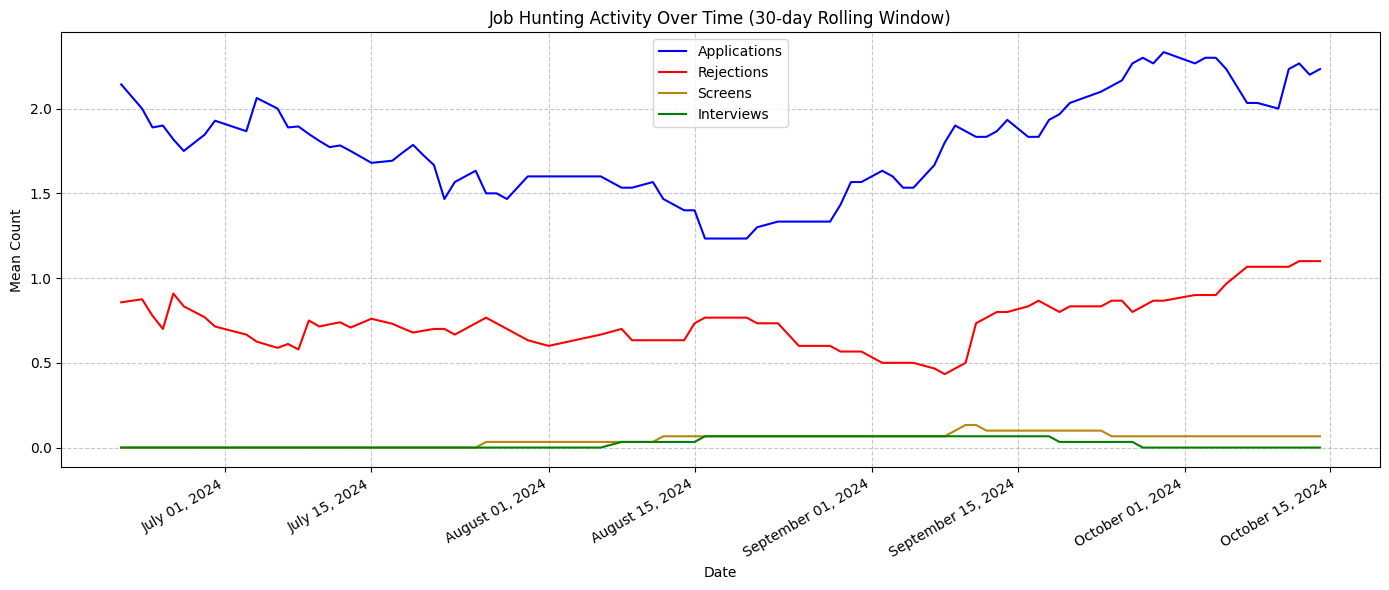

In [4]:

# Count job hunting activity since last day of work
row_objs_list = []
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
if row_objs_list:
    df = DataFrame(row_objs_list).set_index('action_date')
    
    # Convert neo4j.time.Date to Python date
    df.index = [date(d.year, d.month, d.day) for d in df.index]
    
    # Now convert to datetime
    df.index = pd.to_datetime(df.index)
    
    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(14, 6))  # Increased width to accommodate longer labels
    
    # Plot the data
    window = 30
    min_periods = 7
    ax.plot(df.index, df['total_applications'].rolling(window=window, min_periods=min_periods).mean(), label='Applications', color='blue')
    ax.plot(df.index, df['total_rejections'].rolling(window=window, min_periods=min_periods).mean(), label='Rejections', color='red')
    ax.plot(df.index, df['total_screens'].rolling(window=window, min_periods=min_periods).mean(), label='Screens', color='#b8860b')  # hex code for dark yellow
    ax.plot(df.index, df['total_interviews'].rolling(window=window, min_periods=min_periods).mean(), label='Interviews', color='green')
    
    # Customize the plot
    ax.set_title(f'Job Hunting Activity Over Time ({window}-day Rolling Window)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Mean Count')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Format x-axis ticks
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%A, %B %d'))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%B %d, %Y'))
    # ax.xaxis.set_major_locator(mdates.DayLocator())
    
    # Rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    
    # Adjust layout to prevent cutting off labels
    fig.tight_layout()
    
    # Show the plot
    plt.show()

In [23]:

from datetime import timedelta

def get_periods_activities_list(df, now, timedelta_kwargs={'weeks': 1}):
    activities_list = []
    one_period_ago = now - timedelta(**timedelta_kwargs) + timedelta(days=1)
    date_range = []
    current_date = one_period_ago
    while current_date <= now:
        date_range.append(current_date)
        current_date += timedelta(days=1)
    mask_series = df.index.isin([d.strftime('%Y-%m-%d') for d in date_range])
    if mask_series.any():
        periods_applications = df[mask_series].total_applications.sum()
        periods_rejections = df[mask_series].total_rejections.sum()
        periods_screens = df[mask_series].total_screens.sum()
        periods_interviews = df[mask_series].total_interviews.sum()
    else:
        periods_applications = 0
        periods_rejections = 0
        periods_screens = 0
        periods_interviews = 0
    if periods_applications or periods_rejections or periods_screens or periods_interviews:
        if periods_applications:
            activities_list.append(f'applied to {periods_applications} job' + ('s' if (periods_applications > 1) else ''))
        if periods_rejections:
            activities_list.append(f'got {periods_rejections} rejection' + ('s' if (periods_rejections > 1) else ''))
        if periods_screens:
            activities_list.append(f'got {periods_screens} recruiter screen' + ('s' if (periods_screens > 1) else ''))
        if periods_interviews:
            activities_list.append(f'got {periods_interviews} technical interview' + ('s' if (periods_interviews > 1) else ''))
    
    return activities_list

In [28]:

from datetime import timedelta

# Current date and time
now = datetime.now()

# Get today's stats
activities_list = get_periods_activities_list(df, now, timedelta_kwargs={'days': 1})
if activities_list:
    print('I ' + nu.conjunctify_nouns(activities_list) + ' today, ', end='')

# Get this week's stats
if activities_list:
    print_str = 'so for this week I '
else:
    print_str = 'This week I '
activities_list = get_periods_activities_list(df, now, timedelta_kwargs={'weeks': 1})
if activities_list:
    print_str += nu.conjunctify_nouns(activities_list) + ','
    print(print_str)

# Get total stats
total_applications = df.sum().total_applications
total_rejections = df.sum().total_rejections
total_screens = df.sum().total_screens
total_interviews = df.sum().total_interviews
duration_str = humanize.precisedelta(now - datetime(2024, 6, 13), minimum_unit='days', format='%0.0f')
print(
    f'for a total of {total_applications} job applications, {total_rejections} rejection emails, {total_screens} recruiter screens, and {total_interviews} technical interviews since my contract ended {duration_str} ago.'
)

I applied to 5 jobs today, so for this week I applied to 18 jobs and got 1 rejection,
for a total of 167 job applications, 67 rejection emails, 4 recruiter screens, and 2 technical interviews since my contract ended 4 months and 2 days ago.


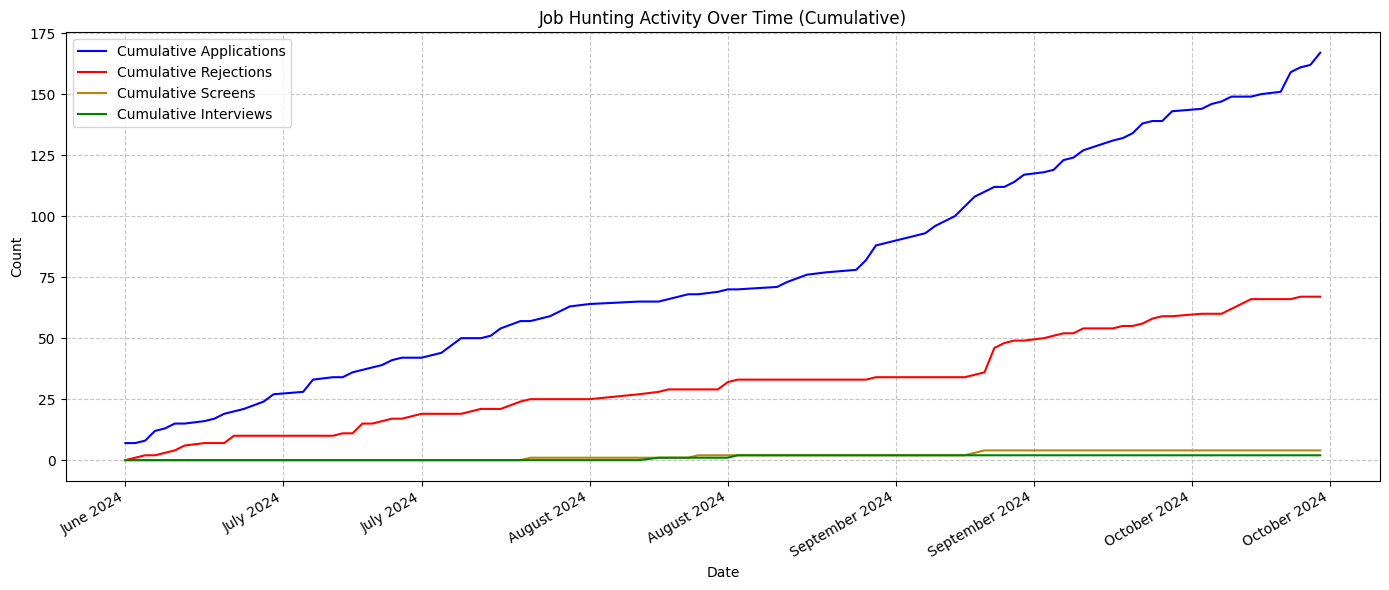

In [29]:

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(14, 6))  # Increased width to accommodate longer labels

# Plot the data
ax.plot(df.cumsum().index, df.cumsum()['total_applications'], label='Cumulative Applications', color='blue')
ax.plot(df.cumsum().index, df.cumsum()['total_rejections'], label='Cumulative Rejections', color='red')
ax.plot(df.cumsum().index, df.cumsum()['total_screens'], label='Cumulative Screens', color='#b8860b')  # hex code for dark yellow
ax.plot(df.cumsum().index, df.cumsum()['total_interviews'], label='Cumulative Interviews', color='green')

# Customize the plot
ax.set_title('Job Hunting Activity Over Time (Cumulative)')
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

# Format x-axis ticks
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%A, %B %d'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B %Y'))
# ax.xaxis.set_major_locator(mdates.DayLocator())

# Rotate and align the tick labels so they look better
fig.autofmt_xdate()

# Adjust layout to prevent cutting off labels
fig.tight_layout()

# Show the plot
plt.show()

In [30]:

# Check if the lru has built its is-qualified classifier
t1 = time.time()
if not (hasattr(lru, 'ISQUALIFIED_LR') and hasattr(lru, 'ISQUALIFIED_CV')):
    lru.build_isqualified_logistic_regression_elements(sampling_strategy_limit=None, verbose=True)
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
speech_str = f'Is-qualified LR elements built in {duration_str}'; print(speech_str)

I have 532,546 is-qualified vocabulary tokens in here
Is-qualified LR elements built in 7 seconds


I have 20,631 hand-labeled qualification strings in here
I have 574,590 is-qualified vocabulary tokens in here
Is-qualified classifer retrained in 11 seconds


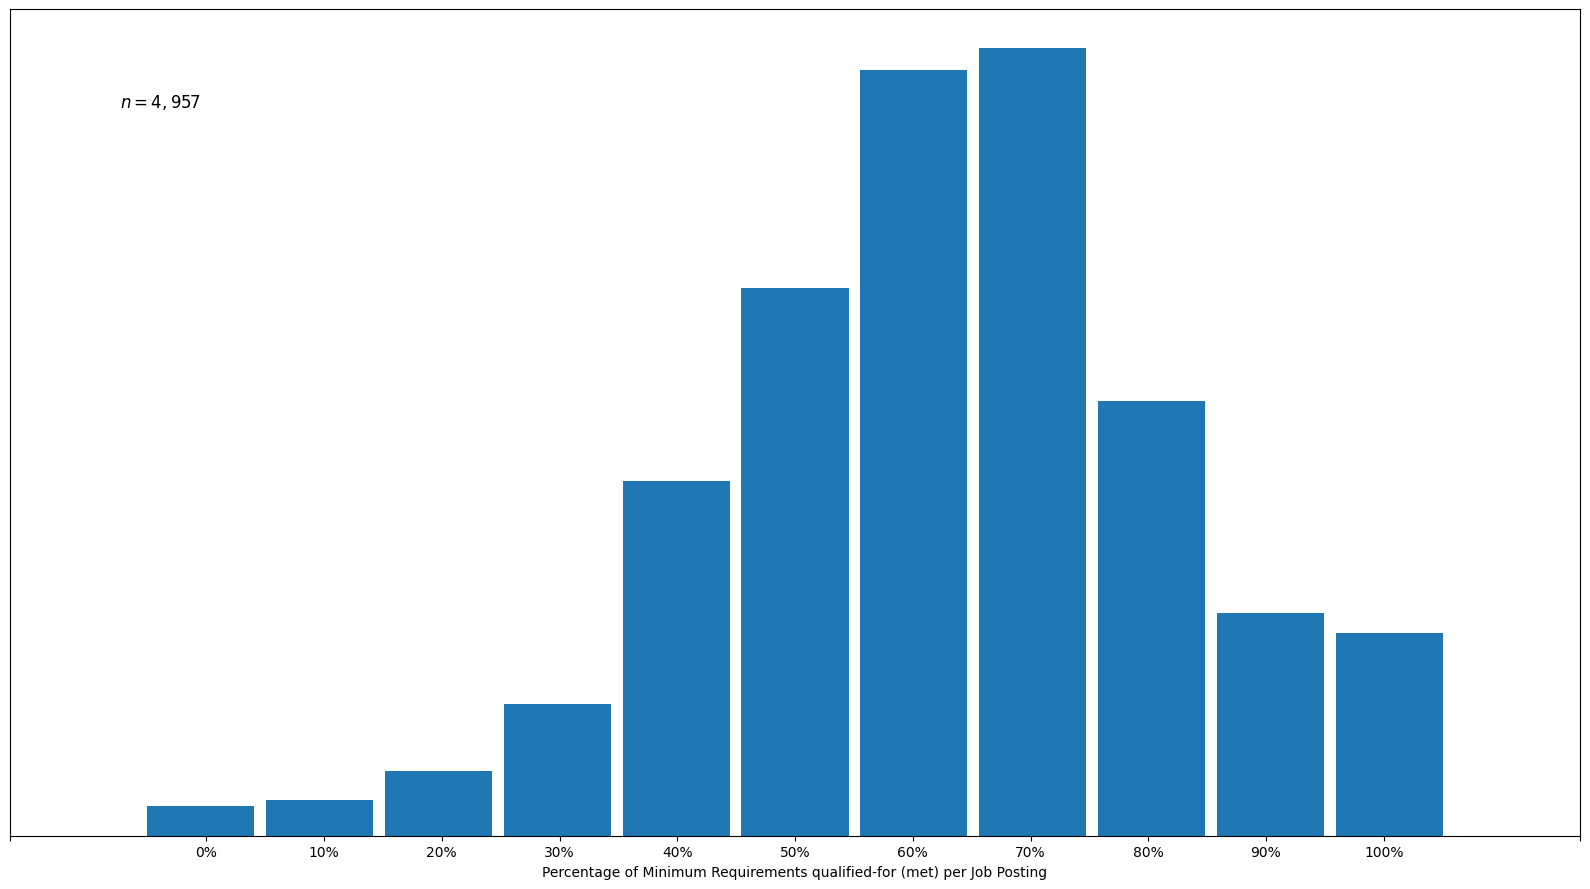

In [31]:

# You need to run this again if you changed the
# qualification dictionary below or in another notebook
t1 = time.time()

# Keep the total retraining time to less than two minutes by adjusting the sampling strategy limit
lru.sync_basic_quals_dict(sampling_strategy_limit=None, verbose=False)

lru.retrain_isqualified_classifier(verbose=True)
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
speech_str = f'Is-qualified classifer retrained in {duration_str}'; print(speech_str)
lru.display_hunting_dataframe_as_histogram(width_inches=16, height_inches=9)


----

In [9]:

# Get all post-scrape activity
cypher_str = '''
    // This query retrieves all FileNames nodes where at least one of the following conditions is met:
    // 1. A technical interview date falls between 2024-06-13 and the current date.
    // 2. The recruiter screen completion date falls between 2024-06-13 and the current date.
    // 3. The rejection email date falls between 2024-06-13 and the current date.
    // 4. The opportunity application email date falls between 2024-06-13 and the current date.
    // The query returns details about the file, including its status and various dates.
    MATCH (fn:FileNames)
    WHERE
        ANY(date IN fn.technical_interview_dates WHERE date >= date("2024-06-13") AND date <= date())
        OR ((fn.recruiter_screen_completion_date <= date()) AND (fn.recruiter_screen_completion_date >= date("2024-06-13")))
        OR ((fn.rejection_email_date <= date()) AND (fn.rejection_email_date >= date("2024-06-13")))
        OR ((fn.opportunity_application_email_date <= date()) AND (fn.opportunity_application_email_date >= date("2024-06-13")))
    RETURN
        fn.file_name AS file_name,
        fn.is_closed AS is_closed,
        fn.is_opportunity_application_emailed AS is_opportunity_application_emailed,
        fn.is_recruiter_screen_completed AS is_recruiter_screen_completed,
        fn.is_tech_interview_completed AS is_tech_interview_completed,
        fn.is_verified AS is_verified,
        fn.opportunity_application_email_date AS opportunity_application_email_date,
        fn.percent_fit AS percent_fit,
        fn.posting_url AS posting_url,
        fn.recruiter_screen_completion_date AS recruiter_screen_completion_date,
        fn.rejection_email_date AS rejection_email_date,
        fn.rejection_email_text AS rejection_email_text,
        fn.technical_interview_dates AS technical_interview_dates;'''
row_objs_list = []
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
if row_objs_list:
    applications_df = DataFrame(row_objs_list)
    mask_series = ~applications_df.opportunity_application_email_date.isnull()
    applications_df.loc[mask_series, 'week_number'] = applications_df.loc[mask_series, 'opportunity_application_email_date'].map(lambda x: x.isocalendar()[1])
    applications_df.loc[mask_series, 'year_number'] = applications_df.loc[mask_series, 'opportunity_application_email_date'].map(lambda x: x.year)
    display(applications_df.sample(3).T)

,82,116,149
file_name,upKoUNAylsvorTHBA2XThw_Senior_Data_Scientist_E...,95ac72f40af9ad30_Research_Engineer_III_Remote_...,7394380669bec7ad_Software_Developer_El_Segundo...
is_closed,None,None,True
is_opportunity_application_emailed,True,True,True
is_recruiter_screen_completed,None,None,None
is_tech_interview_completed,None,None,None
is_verified,None,None,None
opportunity_application_email_date,2024-08-29,2024-09-16,2024-10-03
percent_fit,0.857143,1.0,0.857143
posting_url,https://www.linkedin.com/comm/jobs/view/397057...,https://www.indeed.com/rc/clk/dl?jk=95ac72f40a...,https://www.indeed.com/rc/clk/dl?jk=7394380669...
recruiter_screen_completion_date,None,None,None


In [10]:

mask_series = ~applications_df.recruiter_screen_completion_date.isnull()
print([f'{date.month:02}/{date.day:02}/{date.year}' for date in applications_df[mask_series].sort_values(['recruiter_screen_completion_date']).recruiter_screen_completion_date])
display(applications_df[mask_series].sample(min(3, applications_df[mask_series].shape[0])).T)

['07/26/2024', '08/12/2024', '09/09/2024', '09/10/2024']


,0,25,107
file_name,8fb605a1cad5b94f_Python_Developer_Informatics_...,hMAt6M1ae9pW73omZm4dhw_Senior_Machine_Learning...,Decision_Scientist_Machine_Learning_NLP_LLM_wi...
is_closed,True,True,True
is_opportunity_application_emailed,True,True,True
is_recruiter_screen_completed,True,True,True
is_tech_interview_completed,None,None,None
is_verified,None,None,None
opportunity_application_email_date,2024-08-09,2024-06-27,2024-09-09
percent_fit,1.0,1.0,1.0
posting_url,https://www.indeed.com/rc/clk/dl?jk=8fb605a1ca...,https://www.linkedin.com/comm/jobs/view/391162...,None
recruiter_screen_completion_date,2024-08-12,2024-07-26,2024-09-09


In [11]:

mask_series = ~applications_df.recruiter_screen_completion_date.isnull() | ~applications_df.technical_interview_dates.isnull()
display(applications_df[mask_series].sample(min(3, applications_df[mask_series].shape[0])).T)

,96,0,107
file_name,1bde8bc35d636065_Computer_Vision_Data_Scientis...,8fb605a1cad5b94f_Python_Developer_Informatics_...,Decision_Scientist_Machine_Learning_NLP_LLM_wi...
is_closed,True,True,True
is_opportunity_application_emailed,True,True,True
is_recruiter_screen_completed,True,True,True
is_tech_interview_completed,None,None,None
is_verified,None,None,None
opportunity_application_email_date,2024-09-05,2024-08-09,2024-09-09
percent_fit,0.9,1.0,1.0
posting_url,https://www.indeed.com/rc/clk/dl?jk=1bde8bc35d...,https://www.indeed.com/rc/clk/dl?jk=8fb605a1ca...,None
recruiter_screen_completion_date,2024-09-10,2024-08-12,2024-09-09


In [12]:

mask_series = ~applications_df.technical_interview_dates.isnull()
print([[f'{date.month:02}/{date.day:02}/{date.year}' for date in sublist] for sublist in applications_df[mask_series].sort_values(['technical_interview_dates']).technical_interview_dates])
display(applications_df[mask_series].sample(min(3, applications_df[mask_series].shape[0])).T)

[['08/08/2024'], ['08/16/2024']]


,56,69
file_name,a549539bc1bfd45d_Data_Analyst_Management_Data_...,Amazon_Machine_Learning_Engineer_Boston_MA.html
is_closed,None,None
is_opportunity_application_emailed,True,None
is_recruiter_screen_completed,None,None
is_tech_interview_completed,True,None
is_verified,None,None
opportunity_application_email_date,2024-07-23,None
percent_fit,1.0,0.714286
posting_url,https://www.indeed.com/rc/clk/dl?jk=a549539bc1...,None
recruiter_screen_completion_date,None,None
